# Chemical Library Diversity Analysis: A Complete Workflow

This notebook provides a comprehensive pipeline for analyzing a chemical library. The workflow covers:
1.  **Loading & Standardization**: Reading molecules from various file formats and converting them to a single, canonical representation.
2.  **Featurization**: Calculating physicochemical descriptors (e.g., MW, LogP) and structural fingerprints (e.g., Morgan, MACCS).\n",
3.  **Dimensionality Reduction**: Visualizing the chemical space by projecting high-dimensional fingerprints into 2D using PCA, t-SNE, UMAP, and PaCMAP.
4.  **Clustering**: Grouping similar molecules using KMeans, Agglomerative, and DBSCAN algorithms.
5.  **Diversity Selection**: Picking representative molecules from clusters and using diversity-focused algorithms like MaxMin.
6.  **Visualization & Export**: Generating plots, molecule grids, and exporting results to CSV and SDF formats.
7.  **Interactive Exploration**: Launching an interactive dashboard to explore the chemical space, view molecules, and save selections.

## STEP 1: Imports and Environment Setup

This first cell imports all necessary libraries and sets up the environment. It checks for optional (but recommended) packages like `rdMolStandardize`, `UMAP`, and `tqdm` and prints their availability.

In [1]:
# --- Core Python Libraries ---
import os
import math
import random
import warnings
import pathlib
from typing import List, Tuple, Dict, Optional

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt

# --- RDKit for Cheminformatics ---
from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen, Lipinski, rdMolDescriptors
from rdkit.Chem import SDWriter # For writing SDF files
from rdkit.Chem import Draw
from IPython.display import display

# --- RDKit Optional Modules (availability is checked) ---
try:
    # MolStandardize is crucial for cleaning and canonicalizing molecules.
    from rdkit.Chem.MolStandardize import rdMolStandardize
    HAVE_STD = True
except ImportError:
    rdMolStandardize = None
    HAVE_STD = False

try:
    # QED (Quantitative Estimation of Drug-likeness) is a useful descriptor.
    from rdkit.Chem import QED
    HAVE_QED = True
except ImportError:
    QED = None
    HAVE_QED = False

try:
    # MaxMinPicker is used for diversity selection.
    from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
    HAVE_MAXMIN = True
except ImportError:
    MaxMinPicker = None
    HAVE_MAXMIN = False

# --- Scikit-learn for Machine Learning ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE # For t-SNE dimensionality reduction
from sklearn.metrics import silhouette_score

# --- Optional ML Extras (for advanced visualization) ---
try:
    # UMAP is a powerful non-linear dimensionality reduction technique.
    import umap
    HAVE_UMAP = True
except ImportError:
    umap = None
    HAVE_UMAP = False

try:
    # PaCMAP is another modern dimensionality reduction technique.
    import pacmap
    HAVE_PACMAP = True
except ImportError:
    pacmap = None
    HAVE_PACMAP = False

try:
    # TQDM provides progress bars for long-running operations.
    from tqdm.auto import tqdm
    HAVE_TQDM = True
except ImportError:
    tqdm = None
    HAVE_TQDM = False

# --- Configuration ---
# Suppress non-critical RDKit logging and future warnings for a cleaner output.
RDLogger.DisableLog("rdApp.*")
warnings.filterwarnings("ignore", category=FutureWarning)

# Print status of optional libraries
print(f"RDKit MolStandardize available: {HAVE_STD}")
print(f"RDKit QED available: {HAVE_QED}")
print(f"RDKit MaxMinPicker available: {HAVE_MAXMIN}")
print(f"UMAP available: {HAVE_UMAP}")
print(f"PaCMAP available: {HAVE_PACMAP}")
print(f"TQDM progress bars available: {HAVE_TQDM}")

RDKit MolStandardize available: True
RDKit QED available: True
RDKit MaxMinPicker available: True
UMAP available: True
PaCMAP available: True
TQDM progress bars available: True


## STEP 2: Molecule Standardization

This is a critical pre-processing step. Real-world chemical data is messy. Molecules can be represented with salts, as different tautomers, or in various charge states. Standardization ensures that each unique chemical entity is represented by a single, canonical structure.

The code below defines a robust `standardize_mol` function that:
1.  Handles different RDKit versions by trying multiple import paths for standardization tools.
2.  Applies a pipeline: removes salts, normalizes functional groups, reionizes, uncharges, and selects a canonical tautomer.
3.  Sanitizes the molecule to ensure chemical validity before and after transformations.

In [2]:
# This block robustly imports standardization primitives, handling various RDKit versions.
from typing import Optional
from rdkit import Chem

# --- Gracefully import standardization tools, accommodating different RDKit versions ---
try:
    # Modern RDKit (>=2020.09) centralizes these tools.
    from rdkit.Chem.MolStandardize import rdMolStandardize
    uncharger = rdMolStandardize.Uncharger()
    normalizer = rdMolStandardize.Normalizer()
    fragment_chooser = rdMolStandardize.LargestFragmentChooser(preferOrganic=True)
    tautomer_enumerator = rdMolStandardize.TautomerEnumerator()
    _HAVE_STD_TOOLS = True
except (ImportError, Exception):
    # Fallback for older RDKit versions or if the module is missing.
    warnings.warn("RDKit MolStandardize module not found. Standardization will be limited.")
    _HAVE_STD_TOOLS = False

def sanitize_mol(m: Chem.Mol) -> Optional[Chem.Mol]:
    """Safely sanitizes a molecule, returning None on failure."""
    if m is None:
        return None
    try:
        # SanitizeMol checks for chemical correctness (e.g., valency) and sets aromaticity flags.
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def standardize_mol(m: Chem.Mol) -> Optional[Chem.Mol]:
    """
    Applies a full standardization pipeline to a single RDKit molecule.
    
    Pipeline:
    1. Sanitize input.
    2. Choose the largest organic fragment (removes salts/solvents).
    3. Normalize functional groups to a consistent representation.
    4. Uncharge the molecule to its neutral form.
    5. Enumerate tautomers and select the canonical one.
    6. Final sanitization.
    """
    if m is None:
        return None
    
    # Initial sanitization is good practice.
    m = sanitize_mol(m)
    if m is None: return None

    if _HAVE_STD_TOOLS:
        # Apply the full pipeline if tools are available.
        try:
            # 1. Remove salts and solvents
            m = fragment_chooser.choose(m)
            # 2. Normalize functional groups (e.g., nitro groups)
            m = normalizer.normalize(m)
            # 3. Neutralize the molecule
            m = uncharger.uncharge(m)
            # 4. Select the canonical tautomer
            m = tautomer_enumerator.Canonicalize(m)
        except Exception as e:
            # If any step fails, we return None to indicate a problem.
            # print(f"Standardization failed for a molecule: {e}") # Uncomment for debugging
            return None
    
    # Final sanitization to ensure the output is valid.
    return sanitize_mol(m)

def get_canonical_smiles(m: Chem.Mol) -> Optional[str]:
    """Generates a canonical, isomeric SMILES string for a molecule."""
    if m is None:
        return None
    try:
        # This creates a unique string representation for a given molecule structure.
        return Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
    except Exception:
        return None

print(f"Standardization tools are {'available' if _HAVE_STD_TOOLS else 'NOT available'}.")

Standardization tools are available.


## STEP 3: Data Loading and Cleaning

This section contains functions to load molecules from common file formats (`.sdf`, `.smi`, `.csv`). The main function, `load_and_clean`, orchestrates the process:

1.  Iterates through the input file.
2.  Applies the `standardize_mol` function to each molecule.
3.  Generates a canonical SMILES string to identify and remove duplicates.
4.  Returns a clean, de-duplicated list of RDKit molecule objects and their corresponding SMILES.

In [3]:
def iter_mols_from_file(path: str, smiles_colname: Optional[str] = None):
    """Yields sanitized RDKit molecules from SDF, SMI, or CSV files."""
    ext = pathlib.Path(path).suffix.lower()
    
    if ext == ".sdf":
        # Use SDMolSupplier for SDF files. `removeHs=False` is important for some descriptors.
        suppl = Chem.SDMolSupplier(path, removeHs=False, sanitize=False)
        for m in suppl:
            yield sanitize_mol(m)
            
    elif ext == ".smi":
        # For SMILES files, read line by line.
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith("#"): continue # Skip empty/comment lines
                smi = line.split()[0] # Assume SMILES is the first token
                m = Chem.MolFromSmiles(smi)
                yield sanitize_mol(m)
                
    elif ext == ".csv":
        # For CSV files, use pandas for robust parsing.
        if not smiles_colname:
            raise ValueError("For CSV files, `smiles_colname` must be provided.")
        df = pd.read_csv(path)
        if smiles_colname not in df.columns:
            raise ValueError(f"SMILES column '{smiles_colname}' not found in CSV.")
        for smi in df[smiles_colname].astype(str):
            m = Chem.MolFromSmiles(smi)
            yield sanitize_mol(m)
    else:
        raise ValueError(f"Unsupported file extension: '{ext}'. Use .sdf, .smi, or .csv")

def load_and_clean(input_path: str, smiles_colname: Optional[str] = None, max_n: Optional[int] = None) -> Tuple[List[Chem.Mol], List[str]]:
    """
    Loads, standardizes, and de-duplicates molecules from a file.
    
    Args:
        input_path: Path to the input file (.sdf, .smi, .csv).
        smiles_colname: The name of the SMILES column if input is a CSV.
        max_n: Optional maximum number of unique molecules to load.
        
    Returns:
        A tuple containing (list of RDKit Mols, list of canonical SMILES).
    """
    iterator = iter_mols_from_file(input_path, smiles_colname)
    
    # Use a set to keep track of seen canonical SMILES for efficient de-duplication.
    seen_smiles = set()
    mols = []
    smis = []
    
    # Wrap the iterator with tqdm for a progress bar if available.
    it = tqdm(iterator, desc="Loading & Standardizing") if HAVE_TQDM else iterator
    
    for m_raw in it:
        # Standardize the molecule using the robust function from Step 2.
        m_std = standardize_mol(m_raw)
        if m_std is None:
            continue
            
        # Generate canonical SMILES for de-duplication.
        smi_canon = get_canonical_smiles(m_std)
        if smi_canon is None or smi_canon in seen_smiles:
            continue
            
        # If it's a new, valid molecule, add it to our lists.
        seen_smiles.add(smi_canon)
        mols.append(m_std)
        smis.append(smi_canon)
        
        # Stop if we've reached the desired maximum number of molecules.
        if max_n and len(mols) >= max_n:
            print(f"\nReached max_n limit of {max_n} molecules.")
            break
            
    return mols, smis

## STEP 4: Featurization (Descriptors & Fingerprints)

Now that we have clean molecules, we need to convert them into numerical representations (features) that machine learning algorithms can understand.

1.  **Physicochemical Descriptors**: These are single values that describe the whole molecule (e.g., molecular weight, polarity). They are useful for filtering and building predictive models.
2.  **Molecular Fingerprints**: These are bit vectors where each bit represents the presence or absence of a specific structural feature. They are the foundation for similarity searching, clustering, and diversity analysis.

This section defines functions to calculate a standard set of descriptors and three common fingerprint types:
-   **Morgan**: Circular fingerprints, similar to ECFP. Excellent for similarity searching.
-   **MACCS**: A set of 166 predefined structural keys. Interpretable but less detailed.
-   **RDKit**: A path-based fingerprint.

In [4]:
def compute_physchem_properties(m: Chem.Mol) -> Dict[str, float]:
    """Calculates a dictionary of key physicochemical properties for a molecule."""
    return {
        "MW": Descriptors.MolWt(m), # Molecular Weight
        "LogP": Crippen.MolLogP(m), # Octanol-water partition coefficient
        "TPSA": rdMolDescriptors.CalcTPSA(m), # Topological Polar Surface Area
        "HBD": Lipinski.NumHDonors(m), # Hydrogen Bond Donors
        "HBA": Lipinski.NumHAcceptors(m), # Hydrogen Bond Acceptors
        "RotB": Lipinski.NumRotatableBonds(m), # Rotatable Bonds
        "Rings": rdMolDescriptors.CalcNumRings(m), # Number of Rings
        "Fsp3": rdMolDescriptors.CalcFractionCSP3(m), # Fraction of sp3 hybridized carbons
        "QED": (QED.qed(m) if HAVE_QED else float("nan")), # Quantitative Estimation of Drug-likeness
    }

# --- Fingerprint Generation Functions ---
def get_morgan_fp(m: Chem.Mol, radius=2, nBits=2048):
    """Generates a Morgan fingerprint (ECFP4-like)."""
    return AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nBits)

def get_maccs_fp(m: Chem.Mol):
    """Generates MACCS keys fingerprint."""
    return rdMolDescriptors.GetMACCSKeysFingerprint(m)

def get_rdk_fp(m: Chem.Mol, nBits=2048):
    """Generates an RDKit path-based fingerprint."""
    return Chem.RDKFingerprint(m, fpSize=nBits)

def bitvector_to_numpy(bv) -> np.ndarray:
    """Converts an RDKit ExplicitBitVect to a NumPy array."""
    arr = np.zeros((bv.GetNumBits(),), dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

def build_feature_tables(mols: List[Chem.Mol],
                         need_maccs: bool = True,
                         need_rdk: bool = True,
                         fp_bits: int = 2048,
                         morgan_radius: int = 2) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, Optional[np.ndarray], Optional[np.ndarray]]:
    """
    Computes descriptors and fingerprints for a list of molecules.
    
    Returns:
        - A pandas DataFrame of physicochemical properties.
        - NumPy arrays for the physchem data, Morgan, MACCS, and RDKit fingerprints.
    """
    # Calculate physicochemical properties
    physchem_rows = []
    it_phys = tqdm(mols, desc="Computing Phys-Chem") if HAVE_TQDM else mols
    for m in it_phys:
        physchem_rows.append(compute_physchem_properties(m))
    physchem_df = pd.DataFrame(physchem_rows)

    # Calculate fingerprints
    fp_morgan_list, fp_maccs_list, fp_rdk_list = [], [], []
    it_fp = tqdm(mols, desc="Computing Fingerprints") if HAVE_TQDM else mols
    for m in it_fp:
        fp_morgan_list.append(bitvector_to_numpy(get_morgan_fp(m, morgan_radius, fp_bits)))
        if need_maccs:
            fp_maccs_list.append(bitvector_to_numpy(get_maccs_fp(m)))
        if need_rdk:
            fp_rdk_list.append(bitvector_to_numpy(get_rdk_fp(m, nBits=fp_bits)))

    # Convert lists of arrays to 2D NumPy matrices
    X_physchem = physchem_df.values.astype(np.float32)
    X_morgan = np.vstack(fp_morgan_list).astype(np.uint8)
    X_maccs = np.vstack(fp_maccs_list).astype(np.uint8) if need_maccs else None
    X_rdk = np.vstack(fp_rdk_list).astype(np.uint8) if need_rdk else None
    
    return physchem_df, X_physchem, X_morgan, X_maccs, X_rdk

## STEP 5: Dimensionality Reduction

Visualizing chemical space requires projecting the high-dimensional fingerprint data (e.g., 2048 dimensions) into 2D. This section defines a function to perform this using four different algorithms:

-   **PCA (Principal Component Analysis)**: A fast, linear method that captures the largest axes of variance. Good for a quick global overview.
-   **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: A non-linear method excellent at revealing local cluster structures. Can be slow on large datasets.
-   **UMAP (Uniform Manifold Approximation and Projection)**: A modern, non-linear method that is fast and preserves both local and global structure well. Often the best choice for chemical space visualization.
-   **PaCMAP (Pairwise Controlled Manifold Approximation)**: A newer method designed to offer a good balance of local and global structure preservation.

In [5]:
def reduce_dimensionality(X: np.ndarray, method: str = 'umap', random_state: int = 0, **kwargs) -> np.ndarray:
    """
    Reduces the dimensionality of the feature matrix X to 2D.
    
    Args:
        X: The input data (e.g., scaled physchem descriptors or fingerprints).
        method: The algorithm to use ('pca', 'tsne', 'umap', 'pacmap').
        random_state: Seed for reproducibility of stochastic methods.
        **kwargs: Additional arguments passed to the reducer (e.g., perplexity for t-SNE).
    """
    print(f"Performing dimensionality reduction with {method.upper()}...")
    n_components = 2
    
    if method == 'pca':
        # PCA is deterministic and doesn't need a random_state.
        reducer = PCA(n_components=n_components)
        return reducer.fit_transform(X)
    
    elif method == 'tsne':
        # t-SNE is great for visualization but can be slow.
        # `perplexity` is a key parameter to tune.
        perplexity = kwargs.get('perplexity', 30.0)
        reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state, n_jobs=-1)
        return reducer.fit_transform(X)
        
    elif method == 'umap':
        if not HAVE_UMAP:
            warnings.warn("UMAP not found. Falling back to PCA.")
            return reduce_dimensionality(X, method='pca')
        # UMAP is often the best choice for speed and quality of embedding.
        reducer = umap.UMAP(n_components=n_components, random_state=random_state, 
                              n_neighbors=kwargs.get('n_neighbors', 30), 
                              min_dist=kwargs.get('min_dist', 0.15))
        return reducer.fit_transform(X)
        
    elif method == 'pacmap':
        if not HAVE_PACMAP:
            warnings.warn("PaCMAP not found. Falling back to PCA.")
            return reduce_dimensionality(X, method='pca')
        # PaCMAP is a newer alternative to UMAP and t-SNE.
        reducer = pacmap.PaCMAP(n_components=n_components, random_state=random_state,
                                n_neighbors=kwargs.get('n_neighbors', 30))
        return reducer.fit_transform(X)
        
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")


## STEP 6: Clustering

Clustering algorithms group similar molecules together. This is useful for understanding the structure of a library, identifying chemical series, and selecting diverse subsets. We implement three different types:

-   **KMeans (MiniBatchKMeans)**: A fast, centroid-based method that partitions data into a pre-defined number of `k` clusters. Assumes clusters are spherical.
-   **Agglomerative Clustering**: A hierarchical method that builds a tree of nested clusters. Can be slow for large N.
-   **DBSCAN**: A density-based method that can find arbitrarily shaped clusters and identifies outliers as "noise". It does not require `k` to be specified.

In [6]:
def kmeans_clustering(X: np.ndarray, k: int, batch_size: int = 4096, random_state: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    """Performs K-Means clustering using the scalable MiniBatch variant."""
    km = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=random_state, n_init="auto")
    labels = km.fit_predict(X)
    return labels, km.cluster_centers_

def agglomerative_clustering(X: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Performs hierarchical agglomerative clustering.
    Note: This can be memory-intensive for large datasets.
    """
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = agg.fit_predict(X)
    
    # Calculate cluster centers manually as they are not a direct output.
    centers = []
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            centers.append(cluster_points.mean(axis=0))
        else:
            centers.append(np.zeros(X.shape[1], dtype=np.float32)) # Handle empty clusters
    return labels, np.vstack(centers)

def dbscan_clustering(X: np.ndarray, eps: float = 2.0, min_samples: int = 15, metric: str = "euclidean") -> Tuple[np.ndarray, np.ndarray]:
    """
    Performs DBSCAN clustering. Noise points are assigned the label -1.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=-1)
    labels = db.fit_predict(X)
    
    # Calculate centers for non-noise clusters for convenience.
    unique_labels = [c for c in np.unique(labels) if c != -1]
    if not unique_labels:
        # If all points are noise, return no centers.
        centers = np.zeros((0, X.shape[1]), dtype=np.float32)
    else:
        centers = np.vstack([X[labels == c].mean(axis=0) for c in unique_labels]).astype(np.float32)
        
    return labels, centers

def dbscan_clustering_on_fingerprints(X_bits: np.ndarray, eps: float = 0.35, min_samples: int = 15) -> Tuple[np.ndarray, np.ndarray]:
    """
    A wrapper for DBSCAN specifically for binary fingerprint data, using the Jaccard distance metric.
    The Jaccard distance is equivalent to 1 - Tanimoto similarity.
    """
    # Convert uint8 array to boolean for Jaccard metric compatibility.
    X_bool = (X_bits > 0).astype(bool, copy=False)
    return dbscan_clustering(X_bool, eps=eps, min_samples=min_samples, metric="jaccard")

def estimate_k_with_silhouette(X: np.ndarray, k_range: Tuple[int, int, int] = (20, 80, 10), sample_size: int = 10000, random_state: int = 0) -> int:
    """
    Estimates the optimal number of clusters (k) using the silhouette score on a sample of the data.
    """
    if X.shape[0] > sample_size:
        # Subsample the data for faster computation.
        rng = np.random.default_rng(random_state)
        idx = rng.choice(X.shape[0], size=sample_size, replace=False)
        X_sample = X[idx]
    else:
        X_sample = X
        
    best_k, best_score = -1, -1.0
    k_min, k_max, step = k_range
    
    print(f"Estimating k using silhouette score on {X_sample.shape[0]} samples...")
    for k in range(k_min, k_max + 1, step):
        km = MiniBatchKMeans(n_clusters=k, random_state=random_state, n_init="auto", batch_size=2048)
        labels = km.fit_predict(X_sample)
        if len(np.unique(labels)) < 2:
            continue # Silhouette score requires at least 2 clusters.
        try:
            score = silhouette_score(X_sample, labels)
            print(f"  k={k}, Silhouette Score = {score:.4f}")
            if score > best_score:
                best_k, best_score = k, score
        except Exception as e:
            print(f"Could not compute silhouette score for k={k}: {e}")
            
    return best_k if best_k != -1 else k_min

## STEP 7: Representative Molecule Selection

After clustering, we often want to select a few representative compounds from each cluster. This is useful for creating a smaller, diverse subset of the library for screening or analysis. This section provides three methods:

1.  **Centroid-based**: Picks molecules closest to the geometric center (centroid) of each cluster. Fast and simple.
2.  **Medoid-based**: Picks the molecule (a "medoid") that is most similar, on average, to all other molecules in its cluster. This is often preferred for fingerprints as the medoid is a real molecule, unlike a centroid which is an average.
3.  **MaxMin Picker**: A pure diversity selection algorithm that is independent of clustering. It iteratively picks molecules that are most dissimilar to the ones already selected, ensuring broad coverage of the chemical space.

In [7]:
def pick_representatives_by_centroid(X: np.ndarray, labels: np.ndarray, centers: np.ndarray, per_cluster: int = 1) -> List[int]:
    """Selects `per_cluster` molecules from each cluster that are closest to the cluster's centroid."""
    representatives = []
    unique_labels = np.unique(labels)
    
    for i, c in enumerate(unique_labels):
        if c == -1: continue # Skip noise points from DBSCAN
        
        # Get indices of all points in the current cluster
        cluster_indices = np.where(labels == c)[0]
        if len(cluster_indices) == 0: continue
        
        # Get the feature vectors for this cluster
        X_cluster = X[cluster_indices]
        
        # Find the appropriate center (DBSCAN centers are indexed differently)
        center_idx = i if c != -1 and i < len(centers) else c # A bit tricky for DBSCAN
        center = centers[center_idx] if center_idx < len(centers) else X_cluster.mean(axis=0)
        
        # Calculate Euclidean distance from each point to the center
        distances = np.linalg.norm(X_cluster - center, axis=1)
        
        # Get the indices of the points sorted by distance (closest first)
        sorted_dist_indices = np.argsort(distances)
        
        # Select the top `per_cluster` molecules
        num_to_pick = min(per_cluster, len(cluster_indices))
        picked_indices = cluster_indices[sorted_dist_indices[:num_to_pick]]
        representatives.extend(list(picked_indices))
        
    return sorted(representatives)

def pick_medoids_from_fingerprints(X_bits: np.ndarray, labels: np.ndarray, per_cluster: int = 1) -> List[int]:
    """
    Selects medoids from each cluster based on Tanimoto similarity to other cluster members.
    A medoid is an actual point in the cluster that is most representative.
    """
    medoids = []
    unique_labels = [c for c in np.unique(labels) if c != -1]
    
    it = tqdm(unique_labels, desc="Picking Medoids") if HAVE_TQDM else unique_labels
    for c in it:
        cluster_indices = np.where(labels == c)[0]
        if len(cluster_indices) < 1: continue
        
        # To speed up, if cluster is large, compute on a random sample
        sample_indices = cluster_indices
        if len(cluster_indices) > 2000:
            rng = np.random.default_rng(0)
            sample_indices = rng.choice(cluster_indices, size=2000, replace=False)
            
        X_cluster = X_bits[sample_indices].astype(bool)
        
        # Calculate pairwise Tanimoto similarity matrix within the cluster
        # (A & B).sum() / (A | B).sum()
        intersection = X_cluster @ X_cluster.T
        cardinality = X_cluster.sum(axis=1)
        union = cardinality[:, None] + cardinality[None, :] - intersection
        # Handle division by zero for empty fingerprints
        with np.errstate(divide='ignore', invalid='ignore'):
            tanimoto_sim = intersection / union
        tanimoto_sim = np.nan_to_num(tanimoto_sim)
        
        # The medoid is the point with the highest average similarity to all others.
        avg_similarity = tanimoto_sim.mean(axis=1)
        medoid_local_indices = np.argsort(-avg_similarity)[:per_cluster]
        medoids.extend(list(sample_indices[medoid_local_indices]))
        
    return sorted(medoids)

def maxmin_diversity_pick(mols: List[Chem.Mol], target_n: int, fp_kind: str = "morgan", seed: int = 0) -> List[int]:
    """
    Selects a diverse subset of molecules using the MaxMin algorithm.
    This method is independent of any clustering.
    """
    if not HAVE_MAXMIN:
        warnings.warn("MaxMinPicker not available. Skipping MaxMin selection.")
        return []

    fp_funcs = {"morgan": get_morgan_fp, "maccs": get_maccs_fp, "rdk": get_rdk_fp}
    if fp_kind not in fp_funcs:
        raise ValueError(f"Invalid fp_kind '{fp_kind}'. Choose from {list(fp_funcs.keys())}")
    
    print(f"Performing MaxMin picking for {target_n} molecules using {fp_kind} fingerprints...")
    fps = [fp_funcs[fp_kind](m) for m in mols]
    picker = MaxMinPicker()
    
    # The picker needs a distance function. Tanimoto distance = 1 - Tanimoto similarity.
    def tanimoto_dist_func(i, j, fps_list=fps):
        return 1.0 - DataStructs.TanimotoSimilarity(fps_list[i], fps_list[j])
    
    pick_indices = picker.LazyPick(tanimoto_dist_func, len(fps), target_n, seed=seed)
    return list(pick_indices)

## STEP 8: Visualization and Export Utilities

This section provides helper functions for:

-   **Plotting**: Creating 2D scatter plots of the embeddings and bar charts of cluster sizes.
-   **Exporting**: Writing selected molecules and their properties to `.sdf` and `.csv` files.
-   **Drawing Grids**: Rendering grids of molecule structures with their properties for visual inspection.

In [8]:
def plot_scatter_2d(X2d: np.ndarray, labels: np.ndarray, title: str):
    """Generates a 2D scatter plot of the embedding, colored by labels."""
    plt.figure(figsize=(10, 8))
    # Use a specific colormap and handle noise points (-1) by coloring them grey.
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('viridis', len(unique_labels))
    for i, label in enumerate(unique_labels):
        if label == -1:
            color = 'lightgray'
            point_label = 'Noise'
        else:
            color = colors(i)
            point_label = f'Cl {label}'
        
        cluster_points = X2d[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], s=8, alpha=0.7, label=point_label)
        
    plt.title(title, fontsize=16)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.tight_layout()
    plt.show()

def plot_cluster_sizes(labels: np.ndarray, title: str):
    """Generates a bar plot showing the number of molecules in each cluster."""
    vals, counts = np.unique(labels, return_counts=True)
    # Separate noise points for clarity in the plot.
    noise_mask = vals == -1
    noise_count = counts[noise_mask][0] if np.any(noise_mask) else 0
    
    cluster_vals = vals[~noise_mask]
    cluster_counts = counts[~noise_mask]
    
    # Sort clusters by size for better visualization.
    order = np.argsort(-cluster_counts)
    cluster_vals, cluster_counts = cluster_vals[order], cluster_counts[order]
    
    plt.figure(figsize=(12, 5))
    plt.bar([str(v) for v in cluster_vals], cluster_counts)
    plt.title(f"{title} (Noise points: {noise_count})", fontsize=16)
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Molecules")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def write_sdf(path: str, mols: List[Chem.Mol], df: pd.DataFrame, row_indices: List[int]):
    """Writes a subset of molecules to an SDF file, including properties from a DataFrame."""
    print(f"Writing {len(row_indices)} molecules to {path}...")
    with SDWriter(path) as writer:
        for idx in row_indices:
            m = Chem.Mol(mols[idx]) # Create a copy to avoid modifying the original
            # Add all columns from the dataframe as SD properties.
            for col in df.columns:
                val = df.iloc[idx][col]
                if not pd.isna(val):
                    m.SetProp(str(col), str(val))
            writer.write(m)

# --- Main Workflow Execution ---

Now we will run the complete analysis pipeline. This is the main part of the notebook where you set parameters and execute the steps defined above.

## STEP 9: Set Parameters

**ACTION REQUIRED**: Configure the parameters in the cell below to match your input file and analysis goals.

In [9]:
# === 1. Input and Output Configuration ===
# --- Option A: SMILES file ---
INPUT_PATH = "Enamine.smi"  # Path to your input file
CSV_SMILES_COL = None             # Not used for .smi files

# --- Option B: SDF file ---
# INPUT_PATH = "my_library.sdf"
# CSV_SMILES_COL = None

# --- Option C: CSV file ---
# INPUT_PATH = "my_library.csv"
# CSV_SMILES_COL = "SMILES" # <-- IMPORTANT: Set the name of your SMILES column

OUT_DIR = "Enamine_library_analysis_output" # Directory to save all results

# If your file is very large, set a limit on the number of molecules to process.
# Set to None to process the entire file.
MAX_MOLECULES_TO_LOAD = 50000

# === 2. Clustering Parameters ===
# Set to True to automatically estimate the best 'k' for KMeans using the silhouette method.
# Set to False to use the K_DEFAULT value.
AUTO_ESTIMATE_K = True
K_DEFAULT = 50  # Default number of clusters for KMeans/Agglomerative if AUTO_ESTIMATE_K is False

# Parameters for DBSCAN (may require tuning based on your data's density)
DBSCAN_EPS = 0.35           # Epsilon for fingerprint-based DBSCAN (Jaccard distance)
DBSCAN_MIN_SAMPLES = 10     # Minimum samples for DBSCAN

# === 3. Representative Selection Parameters ===
# How many representative molecules to pick from each cluster.
REPS_PER_CLUSTER = 3

# === 4. Diversity Selection (MaxMin) Parameters ===
DO_MAXMIN_PICKING = True
MAXMIN_TARGET_COUNT = 250   # How many diverse molecules to select with MaxMin
MAXMIN_FINGERPRINT = "morgan" # Fingerprint for MaxMin: "morgan", "maccs", or "rdk"

# === 5. Reproducibility ===
SEED = 42 # Use a fixed seed for reproducible results from stochastic algorithms

# --- Setup Environment ---
random.seed(SEED)
np.random.seed(SEED)
os.makedirs(OUT_DIR, exist_ok=True)
print(f"Input file set to: {INPUT_PATH}")
print(f"All outputs will be saved to the directory: '{OUT_DIR}'")

Input file set to: Enamine.smi
All outputs will be saved to the directory: 'Enamine_library_analysis_output'


## STEP 10: Run the Analysis Pipeline

This cell executes the core data processing steps: loading, featurizing, and clustering. It may take some time depending on the size of your library.

In [10]:
# --- 1. Load, Standardize, and De-duplicate Molecules ---
mols, smis = load_and_clean(INPUT_PATH, smiles_colname=CSV_SMILES_COL, max_n=MAX_MOLECULES_TO_LOAD)
print(f"\nSuccessfully loaded and kept {len(mols)} unique, standardized molecules.")

# --- 2. Compute Descriptors and Fingerprints ---
physchem_df, X_physchem, X_morgan, X_maccs, X_rdk = build_feature_tables(mols, need_maccs=True, need_rdk=True)

# --- 3. Scale Physicochemical Data ---
# Scaling is crucial for distance-based algorithms like PCA and KMeans.
scaler = StandardScaler()
X_physchem_scaled = scaler.fit_transform(X_physchem).astype("float32")

# --- 4. Perform Clustering ---
print("\n--- Starting Clustering ---")
# a) K-Means Clustering
if AUTO_ESTIMATE_K:
    # Estimate k on the scaled physicochemical data.
    k_to_use = estimate_k_with_silhouette(X_physchem_scaled, k_range=(20, 100, 10), sample_size=min(10000, len(mols)), random_state=SEED)
    print(f"[Auto-K] Estimated optimal k ≈ {k_to_use}")
else:
    k_to_use = K_DEFAULT
    print(f"[Manual-K] Using default k = {k_to_use}")

lab_km, centers_km = kmeans_clustering(X_physchem_scaled, k=k_to_use, random_state=SEED)

# b) Agglomerative Clustering (only for smaller datasets due to memory usage)
N = X_physchem_scaled.shape[0]
if N <= 40000 and k_to_use < N:
    lab_ag, centers_ag = agglomerative_clustering(X_physchem_scaled, k=k_to_use)
else:
    print("[Agglomerative] Skipped because dataset is too large (N > 40,000). This is to prevent high memory usage.")
    lab_ag, centers_ag = np.full((N,), -1, dtype=int), np.zeros((0, X_physchem_scaled.shape[1]), dtype=np.float32)

# c) DBSCAN on Fingerprints (better for finding structural series)
lab_db, centers_db = dbscan_clustering_on_fingerprints(X_morgan, eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES)

print("\n--- Clustering Summary ---")
print(f"KMeans found {len(np.unique(lab_km))} clusters.")
if np.any(lab_ag != -1): print(f"Agglomerative found {len(np.unique(lab_ag))} clusters.")
print(f"DBSCAN found {len(np.unique(lab_db)) - 1} clusters and {np.sum(lab_db == -1)} noise points.")

Loading & Standardizing: 0it [00:00, ?it/s]


Successfully loaded and kept 5755 unique, standardized molecules.


Computing Phys-Chem:   0%|          | 0/5755 [00:00<?, ?it/s]

Computing Fingerprints:   0%|          | 0/5755 [00:00<?, ?it/s]


--- Starting Clustering ---
Estimating k using silhouette score on 5755 samples...


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


  k=20, Silhouette Score = 0.1130


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


  k=30, Silhouette Score = 0.1122


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


  k=40, Silhouette Score = 0.1120


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


  k=50, Silhouette Score = 0.1134


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


  k=60, Silhouette Score = 0.1186


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


  k=70, Silhouette Score = 0.1163


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


  k=80, Silhouette Score = 0.1188


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


  k=90, Silhouette Score = 0.1217


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(


  k=100, Silhouette Score = 0.1241
[Auto-K] Estimated optimal k ≈ 100

--- Clustering Summary ---
KMeans found 100 clusters.
Agglomerative found 100 clusters.
DBSCAN found 9 clusters and 5587 noise points.


## STEP 11: Select Representatives and Write Results

This cell uses the cluster labels from the previous step to select representative molecules and then compiles all the data into a final results DataFrame, which is saved as a CSV file. It also exports selections to SDF and SMI files.

In [11]:
# --- 1. Select Representatives from Clusters ---
print("\n--- Selecting Representative Molecules ---")
# a) Centroid-based picks from physchem clusters
reps_km_cent = pick_representatives_by_centroid(X_physchem_scaled, lab_km, centers_km, per_cluster=REPS_PER_CLUSTER)
reps_ag_cent = pick_representatives_by_centroid(X_physchem_scaled, lab_ag, centers_ag, per_cluster=REPS_PER_CLUSTER) if np.any(lab_ag != -1) else []

# b) Medoid-based picks from fingerprint clusters (DBSCAN)
reps_db_medoid = pick_medoids_from_fingerprints(X_morgan, lab_db, per_cluster=REPS_PER_CLUSTER)

# c) Pure diversity picks using MaxMin
picks_maxmin = maxmin_diversity_pick(mols, target_n=MAXMIN_TARGET_COUNT, fp_kind=MAXMIN_FINGERPRINT, seed=SEED) if DO_MAXMIN_PICKING else []

print(f"Selected {len(reps_km_cent)} representatives from KMeans (centroid).")
if reps_ag_cent: print(f"Selected {len(reps_ag_cent)} representatives from Agglomerative (centroid).")
print(f"Selected {len(reps_db_medoid)} representatives from DBSCAN (medoid).")
if picks_maxmin: print(f"Selected {len(picks_maxmin)} diverse molecules with MaxMin.")

# --- 2. Compile and Save Full Results Table ---
results_df = pd.DataFrame({
    "SMILES": smis,
    **{c: physchem_df[c] for c in physchem_df.columns}, # Unpack all physchem columns
    "cluster_kmeans": lab_km,
    "cluster_agglomerative": lab_ag,
    "cluster_dbscan": lab_db,
    "is_rep_kmeans_centroid": False,
    "is_rep_agglomerative_centroid": False,
    "is_rep_dbscan_medoid": False,
    "is_rep_maxmin": False,
})

# Mark the selected representatives in the boolean columns
results_df.loc[reps_km_cent, "is_rep_kmeans_centroid"] = True
results_df.loc[reps_ag_cent, "is_rep_agglomerative_centroid"] = True
results_df.loc[reps_db_medoid, "is_rep_dbscan_medoid"] = True
results_df.loc[picks_maxmin, "is_rep_maxmin"] = True

csv_path = os.path.join(OUT_DIR, "full_library_analysis_results.csv")
results_df.to_csv(csv_path, index_label="index")
print(f"\nWrote full results table to: {csv_path}")

# --- 3. Export Selections to SDF and SMI files ---
# Create a combined set of all unique representatives
rep_union = sorted(set(reps_km_cent) | set(reps_ag_cent) | set(reps_db_medoid) | set(picks_maxmin))

write_sdf(os.path.join(OUT_DIR, "representatives_union.sdf"), mols, results_df, rep_union)
write_sdf(os.path.join(OUT_DIR, "representatives_dbscan_medoids.sdf"), mols, results_df, reps_db_medoid)
if DO_MAXMIN_PICKING:
    write_sdf(os.path.join(OUT_DIR, "representatives_maxmin.sdf"), mols, results_df, picks_maxmin)

# Also write a simple SMILES file of the union set
smi_path = os.path.join(OUT_DIR, "representatives_union.smi")
with open(smi_path, "w") as f:
    for i in rep_union:
        f.write(results_df.iloc[i]["SMILES"] + f"\tmol_index_{i}\n")
print(f"Wrote union of representatives to: {smi_path}")


--- Selecting Representative Molecules ---


Picking Medoids:   0%|          | 0/9 [00:00<?, ?it/s]

Performing MaxMin picking for 250 molecules using morgan fingerprints...
Selected 300 representatives from KMeans (centroid).
Selected 298 representatives from Agglomerative (centroid).
Selected 27 representatives from DBSCAN (medoid).
Selected 250 diverse molecules with MaxMin.

Wrote full results table to: Enamine_library_analysis_output\full_library_analysis_results.csv
Writing 771 molecules to Enamine_library_analysis_output\representatives_union.sdf...
Writing 27 molecules to Enamine_library_analysis_output\representatives_dbscan_medoids.sdf...
Writing 250 molecules to Enamine_library_analysis_output\representatives_maxmin.sdf...
Wrote union of representatives to: Enamine_library_analysis_output\representatives_union.smi


## STEP 12: Generate Embeddings and Static Visualizations

This section generates the 2D embeddings using all four methods (PCA, t-SNE, UMAP, PaCMAP) and creates static plots for each clustering result. This provides a comprehensive visual overview of the chemical space and the performance of each clustering algorithm.

Performing dimensionality reduction with PCA...
Performing dimensionality reduction with TSNE...
Performing dimensionality reduction with UMAP...


C:\Users\crtom\anaconda3\envs\chemdiv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Performing dimensionality reduction with PACMAP...

--- Generating Static Plots ---


C:\Users\crtom\AppData\Local\Temp\ipykernel_4368\1115048061.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


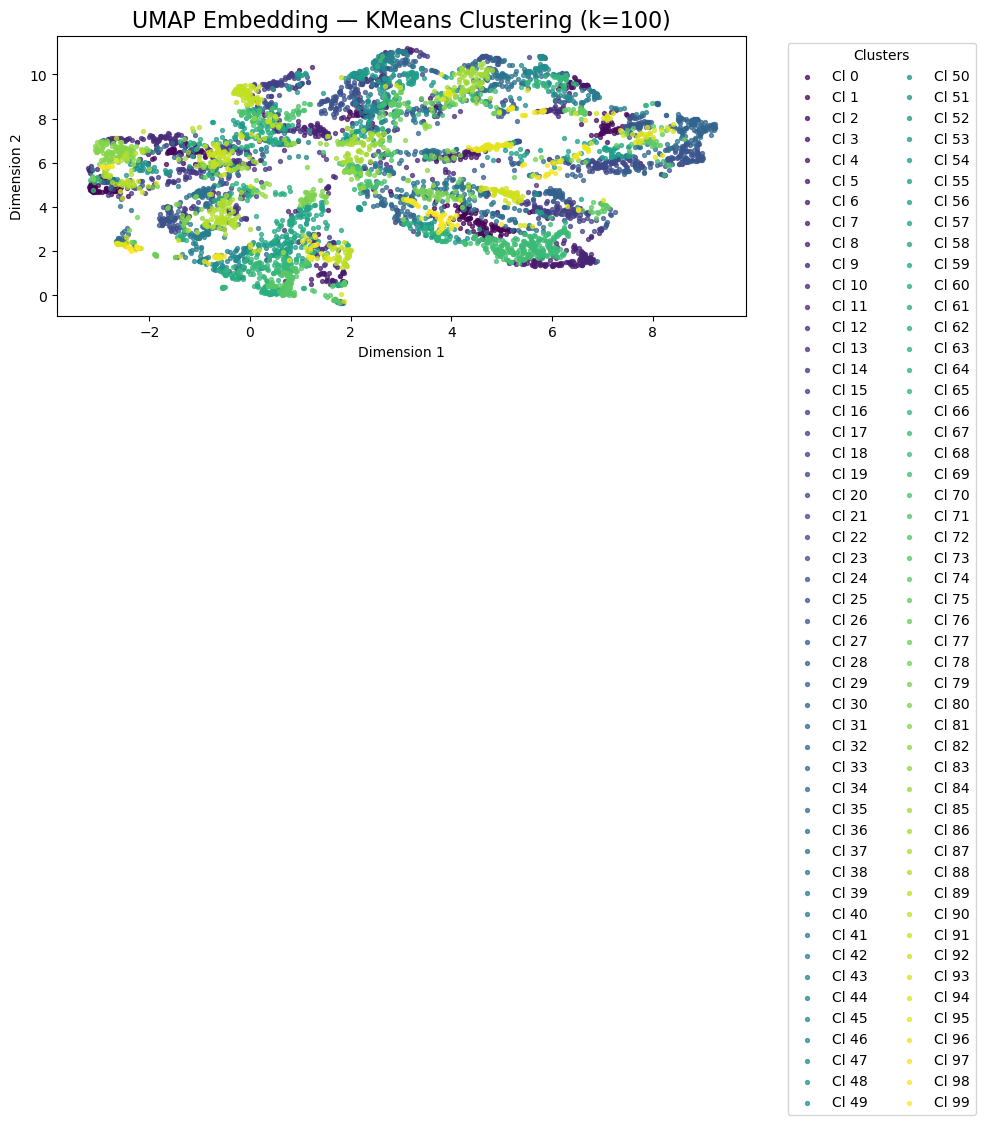

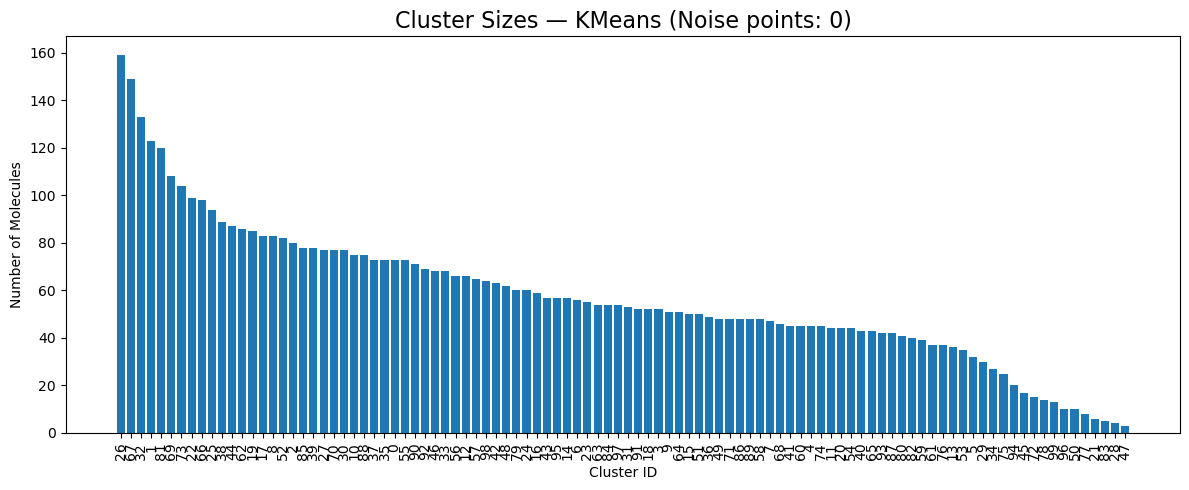

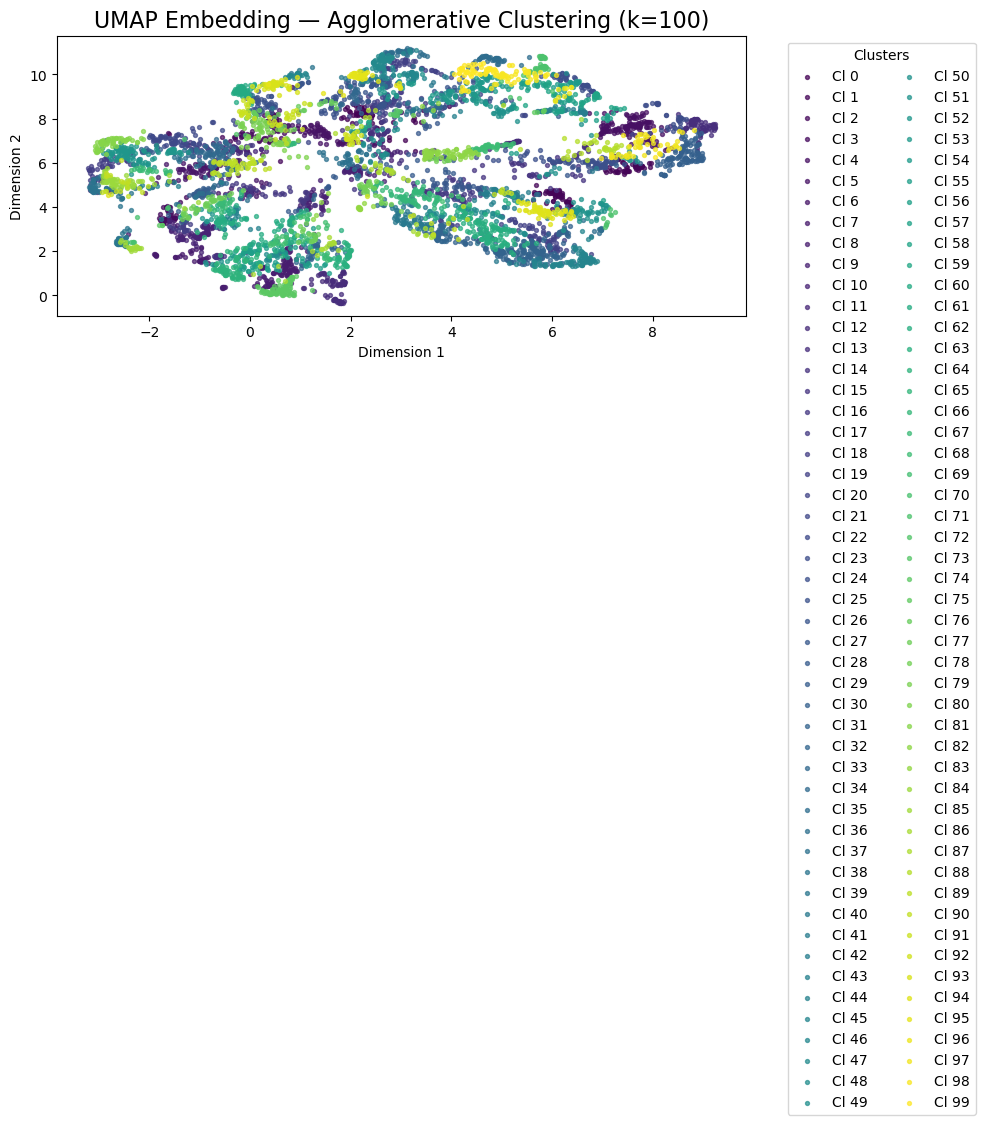

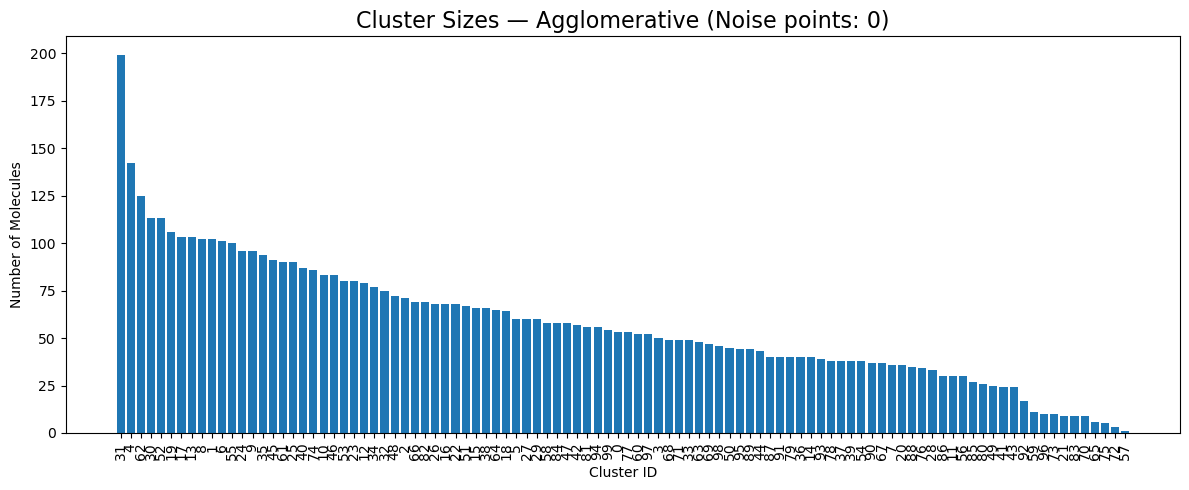

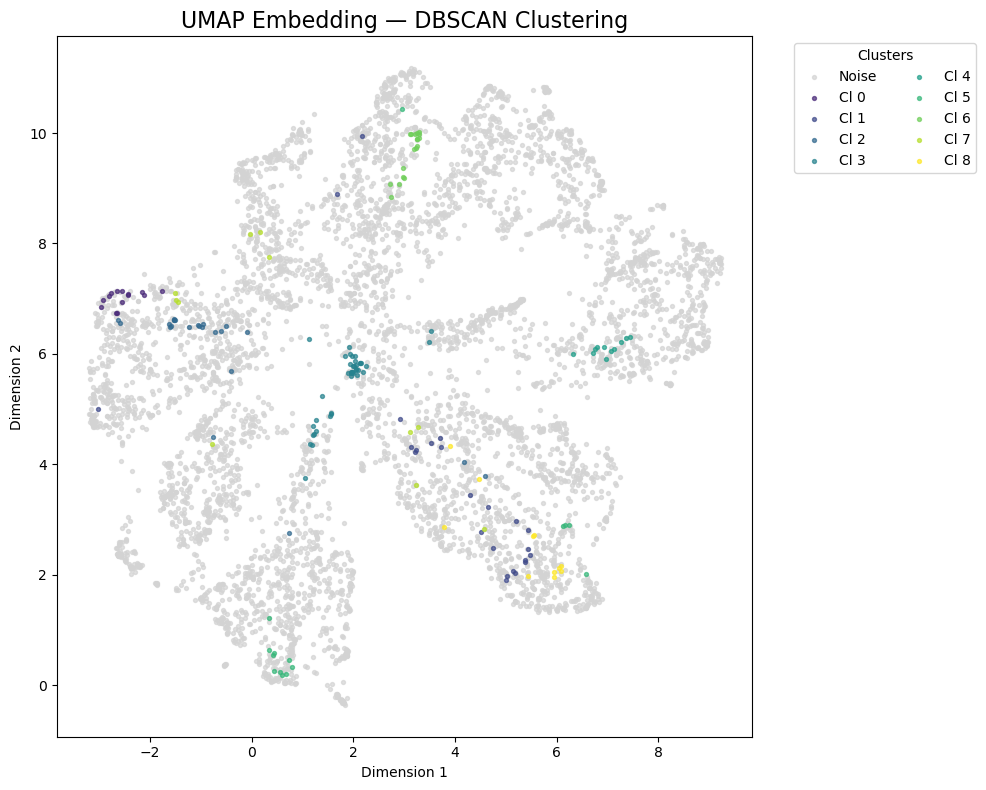

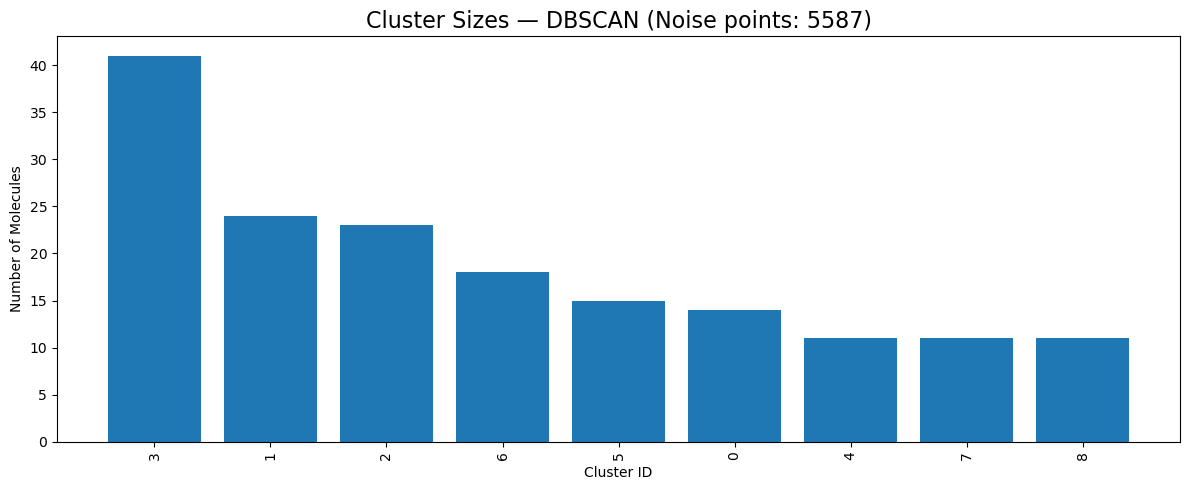

In [12]:
# --- 1. Generate 2D Embeddings ---
# We will generate embeddings from the scaled physicochemical data.
# For chemical space, using fingerprints (e.g., X_morgan) is also a great option.
embedding_input = X_physchem_scaled

X2d_pca = reduce_dimensionality(embedding_input, method='pca', random_state=SEED)
X2d_tsne = reduce_dimensionality(embedding_input, method='tsne', random_state=SEED, perplexity=30.0)
X2d_umap = reduce_dimensionality(embedding_input, method='umap', random_state=SEED)
X2d_pacmap = reduce_dimensionality(embedding_input, method='pacmap', random_state=SEED)

# Store embeddings in the results dataframe for later use
results_df['PCA1'], results_df['PCA2'] = X2d_pca[:, 0], X2d_pca[:, 1]
results_df['tSNE1'], results_df['tSNE2'] = X2d_tsne[:, 0], X2d_tsne[:, 1]
results_df['UMAP1'], results_df['UMAP2'] = X2d_umap[:, 0], X2d_umap[:, 1]
results_df['PaCMAP1'], results_df['PaCMAP2'] = X2d_pacmap[:, 0], X2d_pacmap[:, 1]

print("\n--- Generating Static Plots ---")
# --- 2. Visualize Clustering Results on the UMAP Embedding ---
# UMAP is often the best for visualization, so we'll use it for the static plots.

# a) KMeans plots
plot_scatter_2d(X2d_umap, lab_km, f"UMAP Embedding — KMeans Clustering (k={k_to_use})")
plot_cluster_sizes(lab_km, "Cluster Sizes — KMeans")

# b) Agglomerative plots
if np.any(lab_ag != -1):
    plot_scatter_2d(X2d_umap, lab_ag, f"UMAP Embedding — Agglomerative Clustering (k={k_to_use})")
    plot_cluster_sizes(lab_ag, "Cluster Sizes — Agglomerative")

# c) DBSCAN plots
plot_scatter_2d(X2d_umap, lab_db, "UMAP Embedding — DBSCAN Clustering")
plot_cluster_sizes(lab_db, "Cluster Sizes — DBSCAN")

## STEP 13: Interactive Chemical Space Explorer

This final cell launches a powerful interactive dashboard using Plotly and ipywidgets. This allows you to:

-   **Explore the 2D chemical space** by panning and zooming.
-   **Switch** between different embeddings (PCA, t-SNE, UMAP, PaCMAP).
-   **Color** the points by different clustering results or by physicochemical properties.
-   **Hover** over points to see basic info.
-   **Click** on a point to see its 2D structure and detailed properties.
-   **Select** multiple points using the lasso or box select tools to see a grid of their structures.
-   **Save** your selections (images, CSV, SDF, SMI) for further analysis.

In [14]:
# STEP 13: Interactive Chemical Space Explorer (REPLACE WHOLE CELL WITH THIS)

import warnings
try:
    import numpy as np
    import itertools
    import plotly.graph_objects as go
    from ipywidgets import VBox, HBox, Dropdown, Button, Output, HTML, Text, Checkbox
    from IPython.display import display
    from rdkit import Chem
    from rdkit.Chem import Draw
    from rdkit.Chem import rdDepictor
    HAVE_INTERACTIVE_TOOLS = True
except ImportError:
    warnings.warn("Plotly, ipywidgets, or RDKit not found. Skipping interactive explorer.")
    HAVE_INTERACTIVE_TOOLS = False

if HAVE_INTERACTIVE_TOOLS:
    # --- Helper: color palette for cluster labels ---
    def get_palette_for_labels(labels: np.ndarray, noise_color="#BBBBBB"):
        try:
            import plotly.express as px
            q = px.colors.qualitative
            PALETTE = list(itertools.islice(itertools.cycle(q.Plotly + q.Alphabet + q.Dark24), 2000))
        except Exception:
            # Fallback palette if px not available
            base = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
                    "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
            PALETTE = list(itertools.islice(itertools.cycle(base), 2000))
        uniq = np.unique(labels.astype(int))
        lut = {c: (noise_color if c == -1 else PALETTE[i % len(PALETTE)]) for i, c in enumerate(uniq)}
        return [lut.get(int(c), noise_color) for c in labels]

    # --- Helper: return a copy with 2D depiction coords (non-destructive) ---
    def to_2d_depiction(mol, kekulize=True, prefer_coordgen=True):
        """
        Build a copy of `mol` with 2D coordinates computed for depiction.
        Does NOT modify the original molecule.
        """
        if mol is None:
            return None
        pmol = Chem.Mol(mol)
        if kekulize:
            try:
                Chem.Kekulize(pmol, clearAromaticFlags=True)
            except Exception:
                pmol = Chem.Mol(mol)  # fallback if kekulization fails
        try:
            if prefer_coordgen:
                # use CoordGen (often nicer layouts) when available
                rdDepictor.SetPreferCoordGen(True)
            rdDepictor.Compute2DCoords(pmol)
        finally:
            # reset to default RDKit behavior for the rest of the session
            rdDepictor.SetPreferCoordGen(False)
        return pmol

    # columns for embeddings expected in results_df: UMAP1/2, tSNE1/2, PaCMAP1/2, PCA1/2

    class ChemSpaceExplorer:
        def __init__(self, mols_list, df_results):
            self.mols = mols_list
            self.df = df_results
            self._last_selected_indices = []  # track current selection for redraws

            # Physchem columns (optional, used for "Color by" options)
            self.physchem_cols = list(physchem_df.columns) if 'physchem_df' in globals() else []
            # Output dir must exist already
            self.out_dir = OUT_DIR if 'OUT_DIR' in globals() else "."
            self._build_ui()
            self.update_plot(self.embedding_dd.value, self.color_dd.value)

        def _build_ui(self):
            # Figure & base scatter
            self.fig = go.FigureWidget()
            self.scatter = self.fig.add_scattergl(
                mode='markers',
                marker=dict(size=8, opacity=1.0),
                name='Molecules'
            ).data[0]
            self.fig.update_layout(dragmode="lasso", template="plotly_white", height=600)

            # Overlay stars for "picked" compounds (initially empty/hidden)
            self.star = self.fig.add_scattergl(
                mode='markers',
                name='Picked (★)',
                marker=dict(symbol='star', size=10, opacity=1.0, line=dict(width=1)),
                visible=False
            ).data[-1]

            # Embedding options (only include those present)
            emb_all = ['UMAP','tSNE','PaCMAP','PCA']
            emb_present = [e for e in emb_all if f"{e}1" in self.df.columns and f"{e}2" in self.df.columns]
            if not emb_present:
                emb_present = ['UMAP']  # fallback; will error later if cols missing
            self.embedding_dd = Dropdown(options=emb_present, value=emb_present[0], description='Embedding:')

            # Color-by options: any cluster_* columns + physchem columns
            cluster_cols = [c for c in self.df.columns if c.startswith('cluster')]
            color_options = cluster_cols + self.physchem_cols
            default_color = cluster_cols[0] if cluster_cols else (self.physchem_cols[0] if self.physchem_cols else self.df.columns[0])
            self.color_dd = Dropdown(options=color_options, value=default_color, description='Color by:')

            # Picked overlay controls
            self.picked_sets = {}
            if 'rep_union' in globals():           self.picked_sets["Union (rep_union)"] = list(sorted(set(rep_union)))
            if 'reps_km_cent' in globals():        self.picked_sets["KMeans centroid (reps_km_cent)"] = list(sorted(set(reps_km_cent)))
            if 'reps_ag_cent' in globals():        self.picked_sets["Agglomerative centroid (reps_ag_cent)"] = list(sorted(set(reps_ag_cent)))
            if 'reps_db_medoid' in globals():      self.picked_sets["DBSCAN medoid (reps_db_medoid)"] = list(sorted(set(reps_db_medoid)))
            if 'picks_maxmin' in globals():        self.picked_sets["MaxMin diversity (picks_maxmin)"] = list(sorted(set(picks_maxmin)))
            picked_options = list(self.picked_sets.keys()) if self.picked_sets else ["(none)"]
            picked_default = picked_options[0]
                        # NEW: 2D drawing toggle for selected molecules preview
            self.sketch2d_cb = Checkbox(value=True, description="2D sketch")
            self.show_picked = Checkbox(value=bool(self.picked_sets), description="Show picked (★)")
            self.picked_set_dd = Dropdown(options=picked_options, value=picked_default, description="Picked set:")

            # Other controls
            self.clear_btn = Button(description="Clear Selection", button_style="warning")
            self.save_btn = Button(description="Save Selection", button_style="success")
            self.fname_inp = Text(description="Filename:", value="selection")

            # Outputs
            self.info_html = HTML()
            self.status_html = HTML()
            self.img_out = Output()

            # Layout (two rows of controls)
            #controls_top = HBox([self.embedding_dd, self.color_dd,self.sketch2d_cb, self.show_picked])
            #controls_bottom = HBox([ self.picked_set_dd, self.clear_btn, self.fname_inp, self.save_btn])
            controls_top = HBox([self.embedding_dd, self.color_dd,self.picked_set_dd])
            controls_bottom = HBox([self.sketch2d_cb, self.show_picked])
            self.ui = VBox([controls_top, controls_bottom, self.fig, self.info_html, self.status_html, self.img_out])

            # Events
            self.embedding_dd.observe(self._on_controls_change, names='value')
            self.color_dd.observe(self._on_controls_change, names='value')
            self.show_picked.observe(self._on_controls_change, names='value')
            self.picked_set_dd.observe(self._on_controls_change, names='value')
            self.sketch2d_cb.observe(self._on_sketch_toggle, names='value')
            self.scatter.on_selection(self._on_selection)
            self.scatter.on_click(self._on_click)
            self.clear_btn.on_click(self._on_clear)
            self.save_btn.on_click(self._on_save)

        def _on_sketch_toggle(self, change):
            # Re-render the current selection preview with 2D/3D drawing preference
            self._refresh_selection_preview()

        def _on_controls_change(self, change):
            self.update_plot(self.embedding_dd.value, self.color_dd.value)

        def get_current_picked_indices(self):
            if not self.picked_sets:
                return []
            key = self.picked_set_dd.value
            return list(self.picked_sets.get(key, []))

        def update_plot(self, embedding_type, color_by):
            x_col, y_col = f"{embedding_type}1", f"{embedding_type}2"

            with self.fig.batch_update():
                # Base scatter positions & hover
                self.scatter.x = self.df[x_col]
                self.scatter.y = self.df[y_col]
                self.scatter.hovertext = self.df['SMILES'] if 'SMILES' in self.df.columns else None

                # Base scatter coloring
                if color_by.startswith('cluster'):
                    self.scatter.marker.color = get_palette_for_labels(self.df[color_by].values)
                    self.scatter.marker.showscale = False
                else:
                    self.scatter.marker.color = self.df[color_by]
                    self.scatter.marker.colorscale = 'Viridis'
                    self.scatter.marker.showscale = True
                    self.scatter.marker.colorbar.title = color_by

                # Axes & title
                self.fig.layout.xaxis.title = x_col
                self.fig.layout.yaxis.title = y_col
                self.fig.layout.title = f"{embedding_type} Embedding colored by {color_by}"

                # Picked overlay logic
                self.picked_indices = self.get_current_picked_indices() if self.show_picked.value else []
                if self.picked_indices:
                    picked_df = self.df.iloc[self.picked_indices]
                    self.star.x = picked_df[x_col]
                    self.star.y = picked_df[y_col]
                    self.star.hovertext = picked_df['SMILES'] if 'SMILES' in picked_df.columns else None

                    # star colors by cluster (prefer current color if it's a cluster)
                    cluster_col = None
                    if color_by.startswith('cluster') and color_by in self.df.columns:
                        cluster_col = color_by
                    elif 'cluster_dbscan' in self.df.columns:
                        cluster_col = 'cluster_dbscan'
                    else:
                        for c in self.df.columns:
                            if c.startswith('cluster'):
                                cluster_col = c
                                break

                    if cluster_col:
                        self.star.marker.color = get_palette_for_labels(picked_df[cluster_col].values)
                        self.star.marker.showscale = False
                    else:
                        self.star.marker.color = 'black'
                        self.star.marker.showscale = False

                    self.star.visible = True
                else:
                    self.star.x, self.star.y, self.star.hovertext = [], [], []
                    self.star.visible = False

        def _on_selection(self, trace, points, selector):
            self.draw_selection(points.point_inds)

        def _on_click(self, trace, points, state):
            self.draw_selection(points.point_inds)

        def _on_clear(self, b):
            # Clear selected points (visual only)
            self.scatter.selectedpoints = []
            self.draw_selection([])

        def _prep_for_draw(self, mol):
            """
            Depending on the '2D sketch' toggle, return a molecule object
            suitable for drawing:
              - If 2D sketch is ON: return a copy with 2D coords
              - If OFF: return original (uses existing coords, e.g., 3D)
            """
            if self.sketch2d_cb.value:
                return to_2d_depiction(mol, kekulize=True, prefer_coordgen=True)
            return mol

        def draw_selection(self, indices):
            self._last_selected_indices = list(indices) if indices else []
            self._refresh_selection_preview()

        def _refresh_selection_preview(self):
            self.img_out.clear_output(wait=True)
            if not self._last_selected_indices:
                self.info_html.value = "<b>No points selected.</b> Click a point or use lasso/box select."
                return
            self.info_html.value = f"<b>Selected {len(self._last_selected_indices)} molecules.</b>"
            with self.img_out:
                # Limit for speed; prepare 2D/3D as requested
                idxs = self._last_selected_indices[:100]
                mols_to_draw = [self._prep_for_draw(self.mols[i]) for i in idxs]
                legends = [f"#{i}" for i in idxs]
                try:
                    # RDKit >= 2022 can do crisp SVGs inline
                    img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=6, subImgSize=(250, 200),
                                               legends=legends, useSVG=True)
                except TypeError:
                    # Fallback to PIL image on older RDKit
                    img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=6, subImgSize=(250, 200),
                                               legends=legends)
                display(img)

        def _on_save(self, b):
            # Save current selection to CSV/SDF (requires write_sdf defined earlier)
            indices = self.scatter.selectedpoints or []
            name = (self.fname_inp.value or "selection").strip()
            if not indices:
                self.status_html.value = "<b style='color:#d00;'>No selection to save.</b>"
                return
            import os
            import pandas as pd
            df_selection = self.df.iloc[indices]
            csv_path = os.path.join(self.out_dir, f"{name}.csv")
            df_selection.to_csv(csv_path, index=False)
            try:
                write_sdf(os.path.join(self.out_dir, f"{name}.sdf"), self.mols, self.df, list(indices))
                self.status_html.value = f"<b style='color:green;'>Saved {len(indices)} molecules to {name}.csv and {name}.sdf</b>"
            except Exception as e:
                self.status_html.value = f"<b style='color:orange;'>Saved {len(indices)} to {name}.csv; SDF failed: {e}</b>"

    # --- Launch the Explorer ---
    print("\n--- Launching Interactive Explorer ---")
    explorer = ChemSpaceExplorer(mols, results_df)
    display(explorer.ui)



--- Launching Interactive Explorer ---
